<a href="https://colab.research.google.com/github/alex-smith-uwec/NLP_Spring2025/blob/main/word2vec_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets -q

In [ ]:
import gensim
from gensim.models import Word2Vec



from datasets import load_dataset

import spacy
import re
import random
import numpy as np


https://huggingface.co/datasets/legacy-datasets/wikipedia

In [ ]:
# Load the Wikipedia dataset
dataset = load_dataset("wikipedia", "20220301.simple", split="train")

# Convert dataset into a list of tuples (title, text) for efficient random sampling
data_list = list(zip(dataset["title"], dataset["text"]))

# Shuffle the dataset and pick the first N articles
random.shuffle(data_list)
N = 10000
sampled_data = data_list[:N]

# Extract titles and texts separately
titles, text_data = zip(*sampled_data)

In [ ]:
titles[0:50]

('2AM',
 'Military Occupational Specialty',
 'Early world maps',
 'John Landy',
 'Renault Vel Satis',
 'Hiram Johnson',
 'English muffin',
 'Roberto Di Matteo',
 'Beauvais',
 'Ningxia',
 'Agos',
 'Witherslack',
 'Baku Metro',
 'Emperor Seinei',
 'Nature reserve',
 'Punch-Out (disambiguation)',
 'Carmine Falcone',
 'Fumihito, Prince Akishino',
 'Syrup',
 'British Americans',
 'Charles II of England',
 'BREL',
 'Seti I',
 'Sekhar Basu',
 'Wood ash',
 'Unschooling',
 'Brother Rat',
 'Province of Matera',
 'KLM',
 'SMAP',
 'XOR gate',
 'Byker Grove',
 'Protestant Reformation',
 'Lucerne-Stadt (district)',
 'Hideki Kirita',
 'Bad Neuenahr-Ahrweiler',
 'Russeifa',
 'Pedro Pascal',
 'Here Comes the Sun',
 'Randy Jones (drummer)',
 'Shōkyō',
 'Saint-Sauveur-de-Montagut',
 'Chitra Banerjee Divakaruni',
 'Panjkora River',
 'Sheffield Wednesday F.C.',
 'Jun Kokubo',
 'The Bernie Mac Show',
 'Flag of Tennessee',
 'Lorna Gray',
 'Ulysses (novel)')

In [ ]:

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tagger","lemmatizer"])  # Keep only the tokenizer



def preprocess(text):
    text = re.sub(r'\s+', ' ', text)  # Remove excessive spaces
    doc = nlp(text.lower())  # Tokenization
    return [token.text for token in doc if token.is_alpha and len(token) > 1]  # Filter short/non-alphabetic tokens


In [ ]:


from tqdm import tqdm

# Apply preprocessing with progress bar
sentences = [preprocess(article) for article in tqdm(text_data, desc="Processing articles")]

# Remove short sentences with progress bar
sentences = [s for s in tqdm(sentences, desc="Filtering short sentences") if len(s) > 3]




Filtering short sentences: 100%|██████████| 10000/10000 [00:00<00:00, 1249941.59it/s]


In [ ]:


#train model

model = Word2Vec(sentences, vector_size=50, window=5, min_count=3, workers=4, sg=0)#sg=1 is skipgram, sk=0 is bag of words

In [ ]:
# prompt: find the length of the vocabulary of model

print(len(model.wv.key_to_index))


29393


In [ ]:
model.wv.most_similar("physics", topn=10)


[('chemistry', 0.9046871662139893),
 ('mathematics', 0.8294205665588379),
 ('medicine', 0.8285777568817139),
 ('physiology', 0.8062022924423218),
 ('learning', 0.8029208779335022),
 ('biology', 0.7996598482131958),
 ('visual', 0.7977861762046814),
 ('volume', 0.7970251441001892),
 ('management', 0.7967193126678467),
 ('decorations', 0.789868950843811)]

In [ ]:


# Define word pairs that capture gender
male_words = ["he", "man", "king", "brother", "father"]
female_words = ["she", "woman", "queen", "sister", "mother"]

# Compute the average difference vector (gender direction)
gender_vector = np.mean([model.wv[m] - model.wv[f] for m, f in zip(male_words, female_words)], axis=0)

# Find words that align with the gender dimension
similar_to_male = model.wv.most_similar([gender_vector], topn=5)
similar_to_female = model.wv.most_similar([-gender_vector], topn=5)

# Print results in column format
print(f"{'Most Masculine Words':<20} {'Score':<10}    {'Most Feminine Words':<20} {'Score':<10}")
print("-" * 60)
for (male_word, male_score), (female_word, female_score) in zip(similar_to_male, similar_to_female):
    print(f"{male_word:<20} {male_score:<10.4f}    {female_word:<20} {female_score:<10.4f}")


Most Masculine Words Score         Most Feminine Words  Score     
------------------------------------------------------------
king                 0.6193        nepeta               0.3205    
henry                0.5661        broadcasted          0.3153    
pope                 0.5438        antivirus            0.3060    
congregation         0.5338        leaping              0.3020    
iii                  0.5292        lifestyles           0.2939    


In [ ]:
stereotype_pairs = [('carpentry', 'sewing'),('physician', 'nurse'),('surgeon', 'nurse'),('doctor', 'nurse')]
appropriate_pairs = [('man', 'woman'),('brother', 'sister'),('father', 'mother'),('he', 'she'),('him', 'her'),('boy', 'girl')]
random_pairs = [('dog', 'cat'),('carpet','leg'),('hot','cold')]



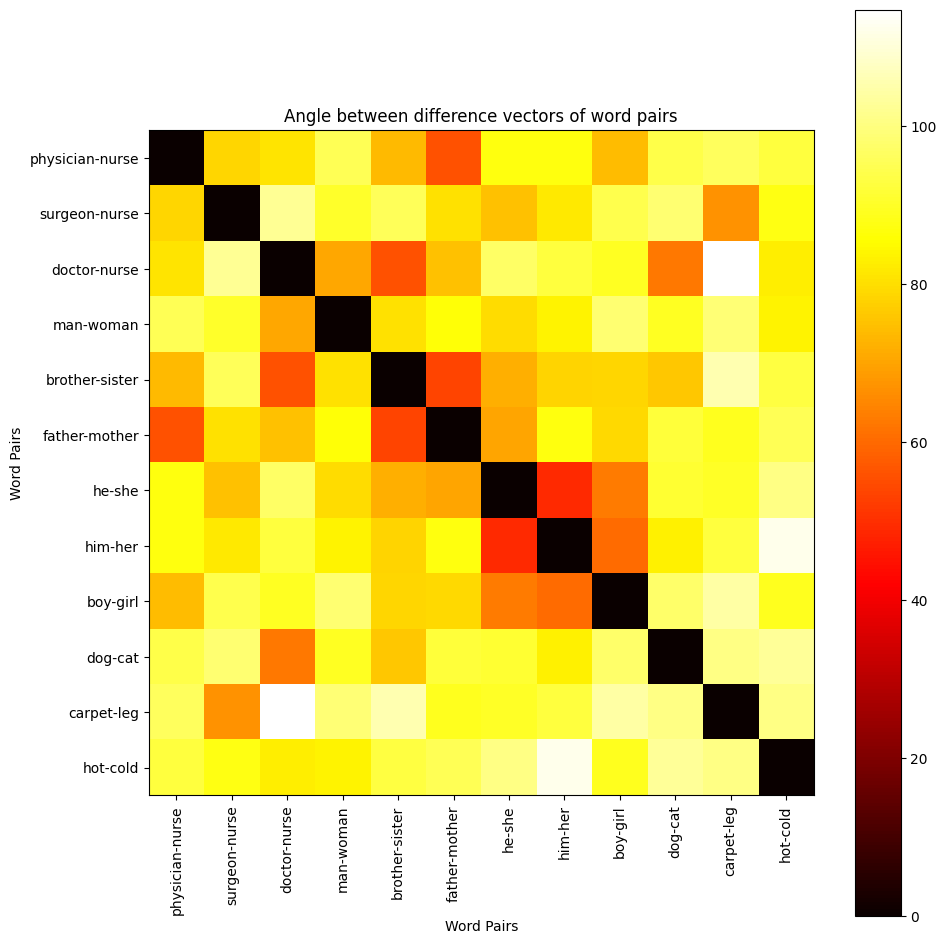

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


def angle_between(v1, v2):
  """Calculates the angle between two vectors in degrees."""
  v1_u = v1 / np.linalg.norm(v1)
  v2_u = v2 / np.linalg.norm(v2)
  return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

# Combine all pairs for processing
all_pairs = stereotype_pairs + appropriate_pairs + random_pairs

# Calculate the difference vectors
# Use model.wv to access word vectors
difference_vectors = {pair: model.wv[pair[0]] - model.wv[pair[1]] for pair in all_pairs if pair[0] in model.wv and pair[1] in model.wv}

# Filter all_pairs to only include pairs present in the vocabulary
all_pairs = [pair for pair in all_pairs if pair[0] in model.wv and pair[1] in model.wv]

# Initialize an empty array to store angles
angles = np.zeros((len(all_pairs), len(all_pairs)))

# Calculate the angles between all pairs of difference vectors
for i, pair1 in enumerate(all_pairs):
    for j, pair2 in enumerate(all_pairs):
        if i == j:
            angles[i, j] = 0  # Angle between a vector and itself is 0 degrees
        else:
            angle = angle_between(difference_vectors[pair1], difference_vectors[pair2])
            angles[i, j] = angle

# Labels for the heat map
pair_labels = [f'{pair[0]}-{pair[1]}' for pair in all_pairs]

# Plotting the heat map with labels
fig, ax = plt.subplots(figsize=(10, 10))
heatmap = ax.imshow(angles, cmap='hot', interpolation='nearest')

# Add color bar with adjusted aspect
cbar = fig.colorbar(heatmap, aspect=20)

# Add labels
ax.set_xticks(np.arange(len(pair_labels)))
ax.set_yticks(np.arange(len(pair_labels)))
ax.set_xticklabels(pair_labels, rotation=90)
ax.set_yticklabels(pair_labels)

ax.set_title('Angle between difference vectors of word pairs')
ax.set_xlabel('Word Pairs')
ax.set_ylabel('Word Pairs')

# Improving layout for better readability
plt.tight_layout()

plt.show()